## **IMPORTAÇÃO DE BIBLIOTECAS**

In [1]:
### BIBLIOTECAS UTILIZADAS NA ETAPA DE MACHINE LEARNING

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob

## PRÉ-PROCESSAMENTO DOS DADOS

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error
from mlforecast import MLForecast
from mlforecast.lag_transforms import RollingMean
from numba import njit

## RANDOM FOREST
from sklearn.ensemble import RandomForestRegressor

## SARIMA
import statsmodels as sm
import pmdarima as pmd

## LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

## **IMPORTAÇÃO DOS DADOS FINAIS**

In [99]:
### IMPORTAÇÃO DOS DADOS FINAIS
path_combs = r'C:\Users\Emanuel\Desktop\PUCMG\TCC\Dataframes'

files = glob.glob(path_combs + '/*.csv')
many_dfs = [pd.read_csv(file, sep=',') for file in files]
df_fuels = pd.concat(many_dfs, ignore_index=False)

df_fuels['data'] = pd.to_datetime(df_fuels['data'])
df_fuels['tipo_comb'] = df_fuels['tipo_comb'].astype('string')

## **PRÉ-PROCESSAMENTO DOS DADOS PARA MODELAGEM**

In [100]:
## RENOMEANDO AS COLUNAS DE DATA, VARIÁVEL TARGET E IDENTIFICADOR DA SÉRIE TEMPORAL PARA SE ADEQUAR AO MLFORECAST
df_fuels = df_fuels.rename(columns={'data': 'ds', 'preco_medio': 'y', 'tipo_comb': 'unique_id'})

In [101]:
## DEFININDO OS OBJETOS PARA CÁLCULO DAS FEATURES COMO DIFERENÇA, LAGS E MÉDIA MÓVEL

### FUNÇÃO DE DIFERENCIAÇÃO DEFINIDA UTILIZANDO O NUMBA (ADEQUADO AO MLFORECAST)
@njit
def difference(x, lag):
    diff_x = np.full_like(x, np.nan)
    for i in range(lag, len(x)):
        diff_x[i] = x[i] - x[i-lag]
    return diff_x

### OBJETO DO MLFORECAST PARA CÁLCULO DE FEATURES COMO LAGS, MÉDIA MÓVEL E VARIÁVEIS DE DATA
get_features = MLForecast(
    models=[],
    freq='D',
    lags=[1,7],
    lag_transforms={
        1: [RollingMean(window_size=3), RollingMean(window_size=7), (difference, 1), (difference, 7)]
    },
    date_features=['dayofweek', 'month', 'year'],
    num_threads=2
)

### APLICAÇÃO DO OBJETO NO DATAFRAME PARA OBTENÇÃO DAS FEATURES
df_fuels = get_features.preprocess(df_fuels, id_col='unique_id', time_col='ds', target_col='y', static_features=[])

In [105]:
## SEPARAÇÃO DOS DATAFRAMES PARA CADA COMBUSTÍVEL E TAMBÉM DA VARIÁVEL TARGET

X_gasolina = df_fuels[df_fuels['unique_id'] == 'GASOLINA'].drop(columns=['y']).reset_index(drop=True)
X_etanol = df_fuels[df_fuels['unique_id'] == 'ETANOL'].drop(columns=['y']).reset_index(drop=True)
y_gasolina = df_fuels[df_fuels['unique_id'] == 'GASOLINA']['y'].reset_index(drop=True)
y_etanol = df_fuels[df_fuels['unique_id'] == 'ETANOL']['y'].reset_index(drop=True)

print(f"Número de dias na série temporal do ETANOL:\n{X_etanol.shape[0]} dias.\n")
print(f"Número de dias na série temporal do GASOLINA:\n{X_gasolina.shape[0]} dias.\n")
print(f"Número de variáveis independentes das duas séries:\n{X_etanol.shape[1]} colunas.")

Número de dias na série temporal do ETANOL:
622 dias.

Número de dias na série temporal do GASOLINA:
622 dias.

Número de variáveis independentes das duas séries:
19 colunas.


In [145]:
tscv = TimeSeriesSplit(n_splits=4, test_size=90)
folds_treino = []
folds_teste = []
for train_index, test_index in tscv.split(X_gasolina):
    folds_treino.append(X.iloc[train_index])
    folds_teste.append(X.iloc[test_index])

In [169]:
print("TREINO\n-----------------")
for i in range(len(folds_treino)):
    print(f"FOLD_{i}: {folds_treino[i].shape[0]} datas\n-----------------")

print("\nTESTE\n-----------------")
for i in range(len(folds_teste)):
    print(f"FOLD_{i}: {folds_teste[i].shape[0]} datas\n-----------------")

TREINO
-----------------
FOLD_0: 262 datas
-----------------
FOLD_1: 352 datas
-----------------
FOLD_2: 442 datas
-----------------
FOLD_3: 532 datas
-----------------

TESTE
-----------------
FOLD_0: 90 datas
-----------------
FOLD_1: 90 datas
-----------------
FOLD_2: 90 datas
-----------------
FOLD_3: 90 datas
-----------------


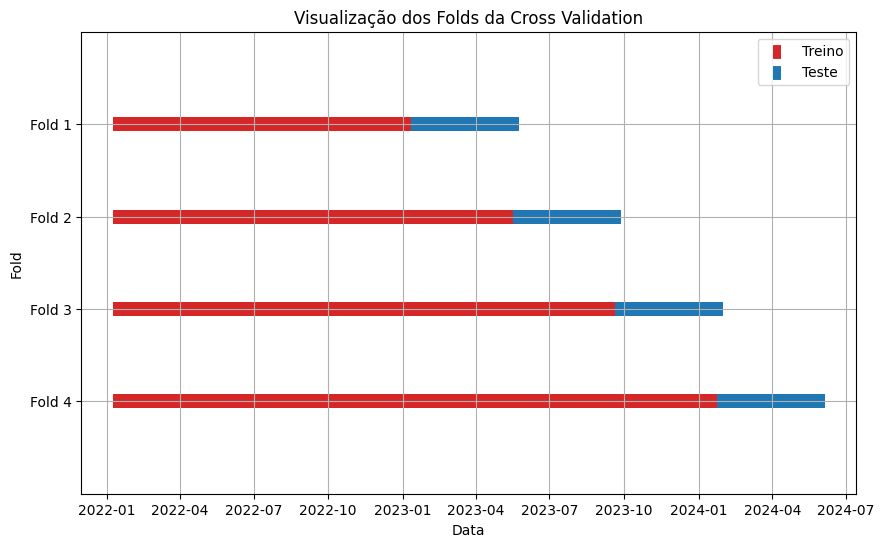

In [141]:
# Define the plotting function
def plot_cross_valid(cv_obj, X, y, datas, ax):

    n_splits = cv_obj.get_n_splits()
    
    for i, (train_index, test_index) in enumerate(cv_obj.split(X)):
        ax.scatter(datas[train_index], [i + 0.5] * len(train_index), c='tab:red', marker='_', lw=10, label='Treino' if i == 0 else "")
        ax.scatter(datas[test_index], [i + 0.5] * len(test_index), c='tab:blue', marker='_', lw=10, label='Teste' if i == 0 else "")
    
    ax.set(ylim=[n_splits + 0.5, -0.5], title='Visualização dos Folds da Cross Validation', xlabel='Data', ylabel='Fold')
    ax.legend(loc='best')
    ax.set_yticks(np.arange(n_splits) + 0.5)
    ax.set_yticklabels([f'Fold {i + 1}' for i in range(n_splits)])
    ax.grid(True)
    return ax

# Plot the cross-validation splits
fig, ax = plt.subplots(figsize=(10, 6))
datas = X_gasolina['ds']
plot_cross_valid(tscv, X_gasolina, y_gasolina, datas, ax)
plt.show()